This notebook is used for data pre-processing and data exploration for the dataset of `OpenFlight` dataset.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

import networkx as nx
import missingno as msno

---
### Overview of dataset

In [12]:
routenames = ['Airline', 'Airline_ID', 'Src_IATA', 'Src_ID', 
            'Des_IATA', 'Des_ID', 'Codeshare', 'Stops', 'Equipment']

routes = pd.read_csv("../routes.dat",header = None,names = routenames,encoding = 'utf-8', na_values='\\N')
routes.dropna(subset=["Airline_ID"], inplace=True)

airlines = pd.read_csv("../airlines.dat",names = ['Airline_ID','Name','Alias','IATA','ICAO','Callsign','Country','Active'])

airports = pd.read_csv("../airports.dat",names = ['Airport_ID','Name','City','Country','IATA','ICAO','Latitude','Longitude',
                                               'Altitude','Timezone','DST','TZ database','Type','Source'], na_values='\\N')

Below we use `msno` to show the information of dataset. White lines mean missing value. 

In `routes` we have a dataset with size 67184\*9. Columns include airline IATA code, airline unique ID, departure and arrival airport IATA code, code share, stop number of this flight and equipment(the aircraft type).

In [13]:
routes.head(2)

,Airline,Airline_ID,Src_IATA,Src_ID,Des_IATA,Des_ID,Codeshare,Stops,Equipment
0,2B,410.0,AER,2965.0,KZN,2990.0,NaN,0,CR2
1,2B,410.0,ASF,2966.0,KZN,2990.0,NaN,0,CR2


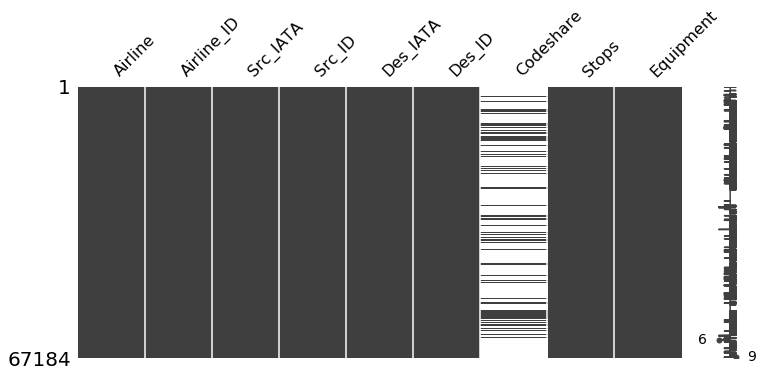

In [14]:
msno.matrix(routes,figsize=(12, 5))#.info()

In `airports` we have a dataset with size 7543\*14. Columns include airport ID, airport name, city, country, IATA and ICAO code of this airport, latitude and longitude, altitude, timezone DST, timezone database, type and data source.

In [15]:
airports.head(2)

,Airport_ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ database,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports


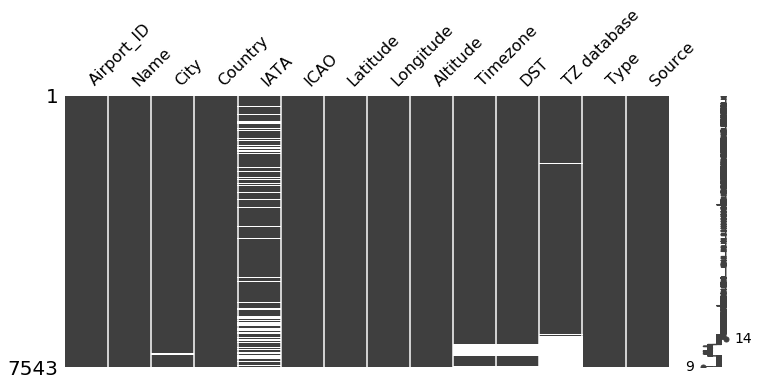

In [16]:
msno.matrix(airports,figsize=(12, 5))#.info()

In `airlines` we have a dataset with size 6162\*8. Columns include airline ID, name, alias, IATA and ICAO code, country and the activeness.

In [17]:
airlines.head(2)

,Airline_ID,Name,Alias,IATA,ICAO,Callsign,Country,Active
0,-1,Unknown,\N,-,NaN,\N,\N,Y
1,1,Private flight,\N,-,NaN,NaN,NaN,Y


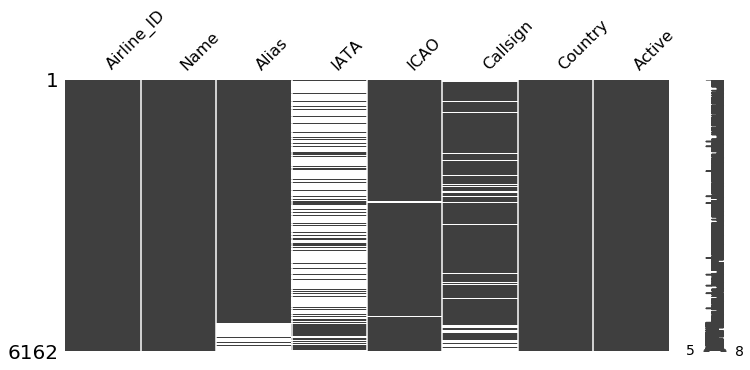

In [18]:
msno.matrix(airlines,figsize=(12, 5))#.info()

---
### Create adjacency matrix
In this part we are going to create the adjacency matrix, where the node is airport and the weight of links will be either the routes number between two airports or the maximum capacity of aircrafts on their routes.

In `routes` the column `Equipment` contains the aircraft types of that routes. We calculated the capacity of that route using the maximum of the aircraft capacity. For routes where multi aircrafts are used, we calculated the averaged capacity. And the `Equipment` not in `capacity.xlsx` are mainly helicopters and other small planes, which are not commercially used, so dropping these routes will not affect much.

In [19]:
routes.drop(columns=['Airline','Airline_ID','Codeshare'],inplace=True)
routes.dropna(subset=['Equipment'],inplace=True)
routes.reset_index(level=0, drop=True,inplace=True)

In [22]:
capacity = pd.read_excel('../capacity.xlsx',header=None,index_col=0)
capacity.columns = ['Equipment','Capacity','test']
capacity = capacity[['Equipment','Capacity']]

In [23]:
capacity.dropna(subset=['Capacity'],inplace=True)
capacity.Equipment = capacity.Equipment.astype('str')
capacity.set_index('Equipment',inplace=True)

In [24]:
cap_list = []
for i in range(len(routes)):
    tmp = routes.iloc[i].Equipment#.get_values()
    cap = []
    for equip in tmp.split():
        try:
            cap_tmp = capacity.loc[equip].Capacity
            cap.append(cap_tmp)
        except:
            continue
    cap_list.append(np.mean(cap))

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
routes['Capacity'] = cap_list
routes.dropna(subset=['Capacity'],inplace=True)

In [26]:
src_cap = routes[['Src_ID','Capacity']].groupby('Src_ID').sum()
des_cap = routes[['Des_ID','Capacity']].groupby('Des_ID').sum()

In [27]:
# merge the capacity ('src_cap' for departure airport;'des_cap' for destination airport)
src_des_cap = pd.concat([src_cap,des_cap], axis=1, sort=True).fillna(0)
src_des_cap.columns = ['Src_cap','Des_cap']
src_des_cap.reset_index(level=0, inplace=True)
src_des_cap.rename(columns={'index':'Airport_ID'},inplace=True)
src_des_cap.head(2)

,Airport_ID,Src_cap,Des_cap
0,1.0,241.666667,241.666667
1,2.0,540.000000,540.000000


In [89]:
portgeo = pd.DataFrame(pd.concat([routes.Src_ID,routes.Des_ID],axis=0).drop_duplicates())
portgeo.rename(columns={0:'Airport_ID'},inplace=True)
portgeo.reset_index(level=0, drop=True,inplace=True)
portgeo = portgeo.merge(src_des_cap,on='Airport_ID')
portgeo.head(5)

,Airport_ID,Src_cap,Des_cap
0,2965.0,3537.333333,3537.333333
1,2966.0,820.000000,820.000000
2,2968.0,2584.000000,2584.000000
3,4029.0,53273.716667,53408.383333
4,6156.0,843.000000,843.000000


In [90]:
# the final .csv containing latittude, longitude, capcity and node index for each airport
portgeo = portgeo.merge(airports[['Name','City','Country','IATA','Latitude','Longitude','Airport_ID']],on='Airport_ID')
#portgeo.reset_index(level=0, inplace=True)
#portgeo.rename(columns={'index':'node_idx'},inplace=True)
portgeo.head(5)

,Airport_ID,Src_cap,Des_cap,Name,City,Country,IATA,Latitude,Longitude
0,2965.0,3537.333333,3537.333333,Sochi International Airport,Sochi,Russia,AER,43.449902,39.956600
1,2966.0,820.000000,820.000000,Astrakhan Airport,Astrakhan,Russia,ASF,46.283298,48.006302
2,2968.0,2584.000000,2584.000000,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,CEK,55.305801,61.503300
3,4029.0,53273.716667,53408.383333,Domodedovo International Airport,Moscow,Russia,DME,55.408798,37.906300
4,6156.0,843.000000,843.000000,Belgorod International Airport,Belgorod,Russia,EGO,50.643799,36.590099


In [92]:
#portgeo.to_csv('../portgeo.csv',index=False)
portgeo = pd.read_csv('../portgeo.csv')

Here we show the top 10 largest capacity airports. Comparing the list to the real top 10 busiest airports worldwide, we can see that two list overlap a lot.

In [93]:
portgeo.sort_values(by='Src_cap',ascending=False).head(10)

,Airport_ID,Src_cap,Des_cap,Name,City,Country,IATA,Latitude,Longitude
423,507.0,143397.716667,142622.800000,London Heathrow Airport,London,United Kingdom,LHR,51.470600,-0.461941
159,3682.0,141866.095238,139436.509524,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,33.636700,-84.428101
266,3364.0,115172.759524,114819.426190,Beijing Capital International Airport,Beijing,China,PEK,40.080101,116.584999
397,1382.0,113329.350000,111403.600000,Charles de Gaulle International Airport,Paris,France,CDG,49.012798,2.550000
409,340.0,106306.785714,105942.619048,Frankfurt am Main Airport,Frankfurt,Germany,FRA,50.033333,8.570556
326,3797.0,99766.800000,100187.400000,John F Kennedy International Airport,New York,United States,JFK,40.639801,-73.778900
298,3484.0,95866.950000,96717.783333,Los Angeles International Airport,Los Angeles,United States,LAX,33.942501,-118.407997
242,3930.0,94953.850000,95024.850000,Incheon International Airport,Seoul,South Korea,ICN,37.469101,126.450996
142,3316.0,94079.000000,95077.833333,Singapore Changi Airport,Singapore,Singapore,SIN,1.350190,103.994003
128,3885.0,88661.621429,88772.954762,Suvarnabhumi Airport,Bangkok,Thailand,BKK,13.681100,100.747002


In [8]:
portgeo.groupby('Country')['Src_cap','Des_cap'].sum().sort_values(by='Src_cap',ascending=False).head(5)

,Src_cap,Des_cap
Country,,
United States,1.769154e+06,1.767567e+06
China,1.309744e+06,1.309989e+06
United Kingdom,4.779132e+05,4.719609e+05
Spain,4.216310e+05,4.229192e+05
Germany,3.879360e+05,3.858549e+05


Next we create the adjacency matrix of airports.

In [58]:
df_openflight = routes.groupby(['Src_IATA','Des_IATA'])['Capacity'].agg(['count','sum']).reset_index()

In [134]:
df_openflight['weight'] = df_openflight['sum']
df_openflight.weight=(df_openflight.weight-df_openflight.weight.min())/(df_openflight.weight.max()-df_openflight.weight.min())

delta = 1
df_openflight.weight = np.exp(-np.square(df_openflight.weight)/delta)


In [135]:
G=nx.from_pandas_edgelist(df_openflight,'Src_IATA','Des_IATA', edge_attr='weight')

In [136]:
L = nx.normalized_laplacian_matrix(G)
e, U = sparse.linalg.eigsh(L, k=10, which='BE')

Text(0.5,1,'top 10 eigenvalue')

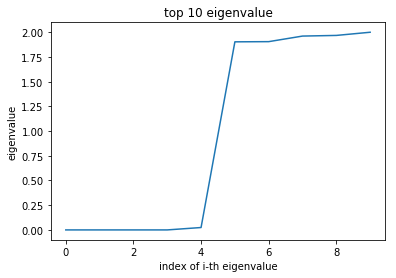

In [137]:
plt.plot(e)
plt.xlabel('index of i-th eigenvalue')
plt.ylabel('eigenvalue')
plt.title('top 10 eigenvalue')

In [138]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
X = U[:,0:5]

k_means = KMeans(init='k-means++', n_clusters=5, n_init=10)
k_means.fit(X)

k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

(-0.1, 0.1)

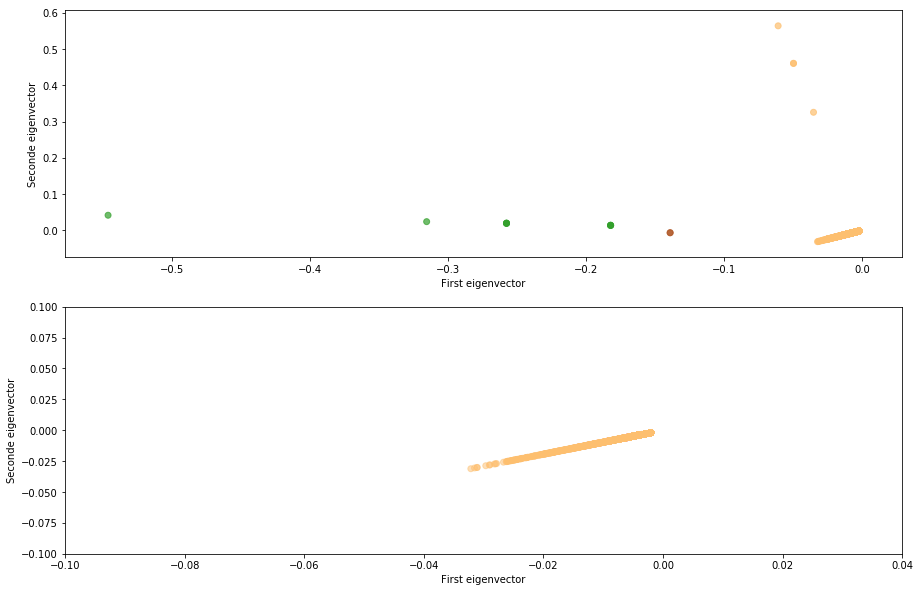

In [139]:
cmap = plt.get_cmap('Paired',5)

fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.7,cmap=cmap)
ax[0].set_xlabel('First eigenvector')
ax[0].set_ylabel('Seconde eigenvector')
#plt.colorbar()
ax[1].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.5,cmap=cmap)
ax[1].set_xlabel('First eigenvector')
ax[1].set_ylabel('Seconde eigenvector')
ax[1].set_xlim(-0.10,0.04)
ax[1].set_ylim(-0.1,0.1)


In [132]:
pos_dict = {}
#portgeo.set_index('IATA',inplace=True)
for node_IATA in list(G.node):
    try:
        longitude = portgeo.loc[node_IATA].Longitude
        latitude = portgeo.loc[node_IATA].Latitude
    except:
        longitude = 0
        latitude = 0        
    pos_dict[node_IATA] = longitude,latitude

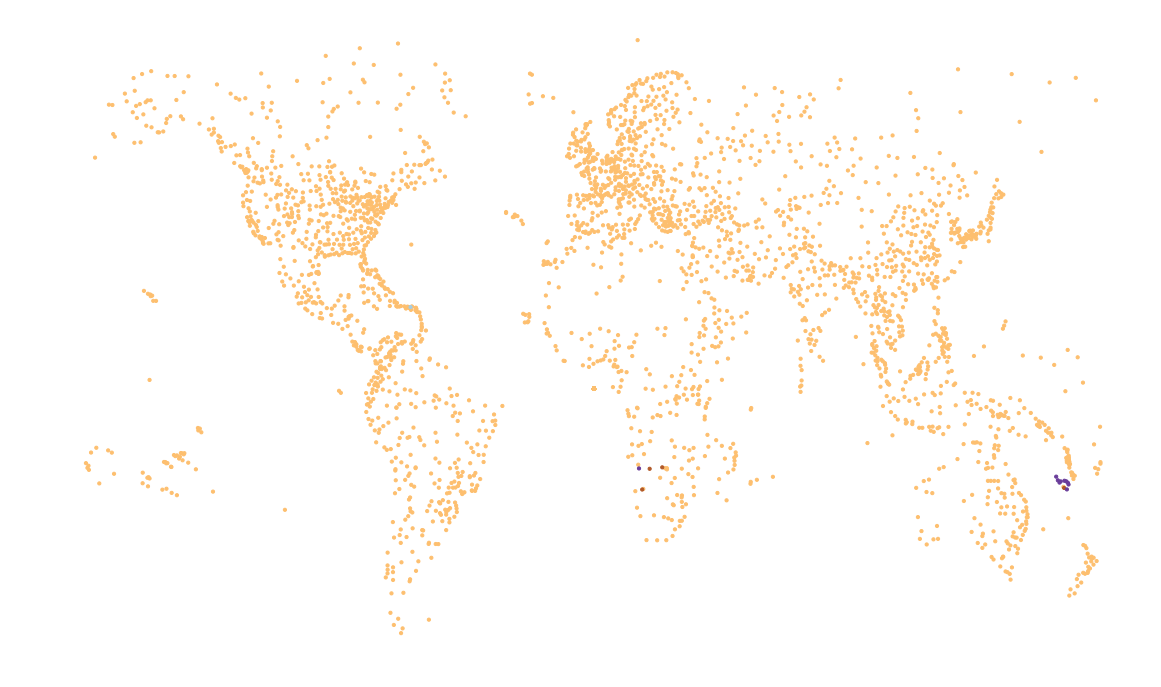

In [133]:
fig, ax = plt.subplots(figsize=(20,12))

nx.draw(G,pos=pos_dict,node_size=10,width=0,node_color=k_means_labels,cmap=cmap)